# 🔍 Exploratory Data Analysis (EDA)

This notebook serves as the foundational phase of our analysis into the gender wage gap using the following [INSEE dataset](https://www.insee.fr/fr/statistiques/7651654#consulter): Description des emplois salariés en 2021 (Bases Tous salariés 2021, Fichier "salariés").

### Key Components of this EDA:
- **Data Refinement & Sample Choice:** We focus on a "strong attachment" workforce (N = 762,661) by filtering for prime-age workers (25–65) with full-time equivalent hours (>= 1607h). To address top-coding, we apply a **Pareto 1.4x multiplier** to the highest salary bracket (Tranche 23), ensuring a more accurate representation of top-tier earnings.

- **Occupational Sorting (Horizontal Segregation)**: We analyze the "Fisherman's Problem" (the structural sorting of women into lower-paying sectors). Our findings confirm a significant negative correlation between sector "feminization" and median wages, with men occupying 72.31% of the top-earning bracket (>50k).

- **Distributions**: Using Kernel Density Estimations (KDE) and Quantile Regression, we map the "topology of inequality." We specifically contrast "Sticky Floors" at the 10th percentile with a widening "Glass Ceiling" at the 90th percentile, proving that the gender penalty intensifies at the upper end of the career ladder.


- **Causal Mapping (DAG):** We define a **Directed Acyclic Graph** that accounts for both horizontal (Sector) and vertical (Job Type) segregation. This provides the theoretical identification roadmap to perform Post-Double-Selection Lasso, effectively partialling out structural confounders (Age, Region) to isolate the unexplained gender wage gap.

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [56]:
# Load the dataset
file_path = '../data/raw/FD_SALAAN_2021_csv/FD_SALAAN_2021.csv'

# Create the DataFrame
df = pd.read_csv(file_path, sep=';', low_memory=False)

print(f"Dataset loaded with {df.shape[0]} observations.")

Dataset loaded with 2403775 observations.


In [57]:
# Check dimensions (Rows, Columns)
print(f"Shape: {df.shape}")

# List all column names 
print(f"Columns: {df.columns.values}")

# Summary of data types and non-null counts
# This is critical for seeing if 'S_NET_EUR' (Salary) is a float or an object
df.info()

Shape: (2403775, 31)
Columns: ['A6' 'A17' 'A38' 'CPFD' 'DATDEB' 'DATFIN' 'DEPR' 'DEPT' 'DOMEMPL'
 'DOMEMPL_EM' 'DUREE' 'FILT' 'REGR' 'REGT' 'SEXE' 'PCS' 'TYP_EMPLOI'
 'CONV_COLL' 'NBHEUR' 'NBHEUR_TOT' 'AGE' 'TRNNETO' 'TRALCHT' 'TREFF'
 'CONT_TRAV' 'CS' 'AGE_TR' 'DATDEB_TR' 'DATFIN_TR' 'DUREE_TR' 'POND']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2403775 entries, 0 to 2403774
Data columns (total 31 columns):
 #   Column      Dtype  
---  ------      -----  
 0   A6          object 
 1   A17         object 
 2   A38         object 
 3   CPFD        object 
 4   DATDEB      float64
 5   DATFIN      float64
 6   DEPR        object 
 7   DEPT        object 
 8   DOMEMPL     float64
 9   DOMEMPL_EM  float64
 10  DUREE       float64
 11  FILT        int64  
 12  REGR        float64
 13  REGT        float64
 14  SEXE        int64  
 15  PCS         object 
 16  TYP_EMPLOI  object 
 17  CONV_COLL   float64
 18  NBHEUR      float64
 19  NBHEUR_TOT  int64  
 20  AGE         float64
 21  TR

In [58]:
# Check for standard NaN/null values first (will later delete them but after filtering)
null_counts = df.isnull().sum()
print("Standard null values per column:")
print(null_counts[null_counts > 0])

# Find columns with empty strings or whitespace
for col in df.select_dtypes(include=['object']).columns:
    empty_count = (df[col].astype(str).str.strip() == '').sum()
    if empty_count > 0:
        print(f"Column {col} has {empty_count} empty string entries.")

Standard null values per column:
A6             96234
A17            96234
A38             8377
CPFD           87887
DATDEB         87891
DATFIN         87887
DEPR             690
DEPT             223
DOMEMPL        87893
DOMEMPL_EM     87895
DUREE          87887
REGR             690
REGT             223
PCS                5
CONV_COLL     580663
NBHEUR         87887
AGE                2
TREFF          87887
CONT_TRAV      89182
CS                 5
AGE_TR             2
DATDEB_TR      87891
DATFIN_TR      87890
DUREE_TR       87887
dtype: int64


In [59]:
# See the first 10 rows to see the raw format
print("Raw TRNNETO values (first 10 rows):")
print(df['TRNNETO'].head(10))

# See all unique 'tranche' codes and how many people are in each
print("\nFrequency of each Salary Tranche:")
print(df['TRNNETO'].value_counts().sort_index())

Raw TRNNETO values (first 10 rows):
0    15
1    12
2    20
3     6
4    15
5    15
6    23
7    17
8    15
9    22
Name: TRNNETO, dtype: int64

Frequency of each Salary Tranche:
TRNNETO
0        240
1        592
2       4794
3      30022
4      39083
5      73460
6      67358
7     120161
8     111967
9     118031
10    111997
11    109501
12    125933
13    144555
14    163694
15    162269
16    149751
17    132108
18    113143
19     95396
20    172700
21    108381
22    114143
23    134496
Name: count, dtype: int64



Statistical Summary:


,TRNNETO
count,2.403775e+06
mean,1.418324e+01
std,5.424315e+00
min,0.000000e+00
25%,1.000000e+01
50%,1.400000e+01
75%,1.900000e+01
max,2.300000e+01


/var/folders/5q/fx2dxhl52b3c_xdmrzcdb99m0000gn/T/ipykernel_47404/713036861.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='TRNNETO', palette='viridis')


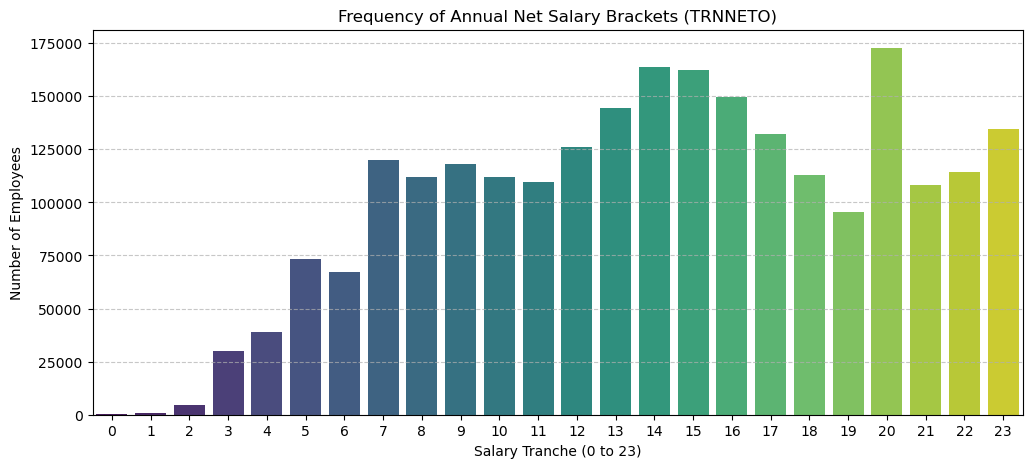

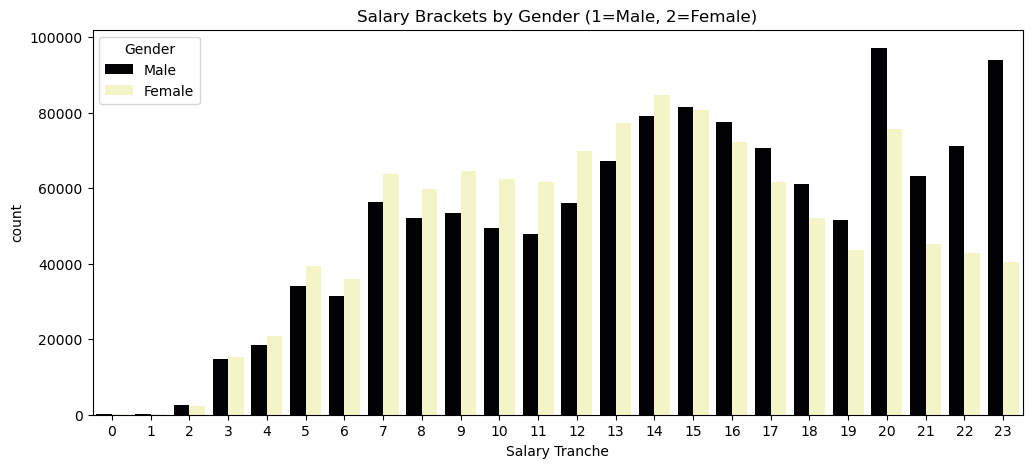

In [60]:
# Descriptive statistics 
# Look closely at the min/max for TRNNETO (Salary) 
print("\nStatistical Summary:")
display(df[['TRNNETO']].describe())


# Discrete Distribution (Count Plot)
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='TRNNETO', palette='viridis')

plt.title('Frequency of Annual Net Salary Brackets (TRNNETO)')
plt.xlabel('Salary Tranche (0 to 23)')
plt.ylabel('Number of Employees')

# Add a grid for better readability
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Gender-Specific Distribution
# Seeing if men/women cluster in different tranches
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='TRNNETO', hue='SEXE', palette='magma')

plt.title('Salary Brackets by Gender (1=Male, 2=Female)')
plt.xlabel('Salary Tranche')
plt.legend(title='Gender', labels=['Male', 'Female'])
plt.show()

In [61]:
# See the breakdown of Gender (SEXE)
# 1 = Male, 2 = Female according to INSEE 
print("\nGender Breakdown:")
print(df['SEXE'].value_counts(normalize=True))


Gender Breakdown:
SEXE
1    0.512067
2    0.487933
Name: proportion, dtype: float64


In [62]:
# See the breakdown by contract type (CONT_TRAV)
print("Actual values in CONT_TRAV:")
print(df['CONT_TRAV'].value_counts())

# See the breakdown by gender (SEXE)
print("\nActual values in SEXE:")
print(df['SEXE'].value_counts())

Actual values in CONT_TRAV:
CONT_TRAV
CDI    1399348
AUT     450321
CDD     240886
TTP     101608
APP      78242
TOA      44188
Name: count, dtype: int64

Actual values in SEXE:
SEXE
1    1230895
2    1172880
Name: count, dtype: int64


In [63]:
# Test: Proportion of women in CDI vs CDD
comparison = df[df['CONT_TRAV'].isin(['CDI', 'CDD'])].copy()
comparison['is_female'] = (comparison['SEXE'] == 2).astype(int)

print("Gender Distribution by Contract Type:")
print(comparison.groupby('CONT_TRAV')['is_female'].mean())

Gender Distribution by Contract Type:
CONT_TRAV
CDD    0.591815
CDI    0.455097
Name: is_female, dtype: float64


In [64]:
# Define the Midpoint Mapping (Euro values)
# For Tranches 0-22, we use the midpoint of the range.
# For Tranche 23 (>50,000€), we apply the 1.4x Pareto multiplier.
# Reference: Armour, Burkhauser, and Larrimore (2016)
lower_bound_top = 50000
pareto_multiplier = 1.4

tranche_to_euro = {
    0: 100, 1: 350, 2: 750, 3: 1250, 4: 1750, 5: 2500, 
    6: 3500, 7: 5000, 8: 7000, 9: 9000, 10: 11000, 
    11: 13000, 12: 15000, 13: 17000, 14: 19000, 15: 21000,
    16: 23000, 17: 25000, 18: 27000, 19: 29000, 20: 32500,
    21: 37500, 22: 45000, 
    23: lower_bound_top * pareto_multiplier  # Result: 70,000€
}

# Cleaning Categorical strings
df['CONT_TRAV'] = df['CONT_TRAV'].astype(str).str.strip().str.upper()

# Apply Filtering 
# Following Bach et al. (2021) for prime-age, full-time workers:
# Age 25-65
# 1607h hours, reference: https://www.service-public.gouv.fr/particuliers/vosdroits/F1911?lang=en
# We use tranche 12 (approx. 15,000€) as the minimum wage cutoff.
# We also ensure we only include those with CDI or CDD contracts.
df_model = df[
    (df['NBHEUR'].fillna(0) >= 1607) & 
    (df['AGE'].fillna(0) >= 25) & 
    (df['AGE'].fillna(0) <= 65) &
    (df['TRNNETO'].fillna(0) >= 12) & 
    (df['CONT_TRAV'].isin(['CDI', 'CDD']))
].copy()

# Feature Engineering: Continuous Wage and Log Wage
df_model['annual_wage_euro'] = df_model['TRNNETO'].map(tranche_to_euro)

# y is the Log-Salary (Standard dependent variable for wage gap regressions)
df_model['y'] = np.log(df_model['annual_wage_euro'])

# Treatment Variable: Female = 1, Male = 0
df_model['female'] = (df_model['SEXE'] == 2).astype(int)


print(f"Final sample size for analysis: {len(df_model)}")
print(f"Mean Log Wage (y): {df_model['y'].mean():.4f}")

Final sample size for analysis: 808288
Mean Log Wage (y): 10.2683


In [65]:
# Check for missing values in the filtered model dataframe
null_counts = df_model.isnull().sum()
null_percentages = (df_model.isnull().sum() / len(df_model)) * 100

# Create a summary table for readability
null_summary = pd.DataFrame({
    'Null Count': null_counts,
    'Percentage (%)': null_percentages.round(2)
})

# Display only columns that actually have nulls
print("--- Missing Values Analysis (Filtered Sample) ---")
print(null_summary[null_summary['Null Count'] > 0])

--- Missing Values Analysis (Filtered Sample) ---
            Null Count  Percentage (%)
A6                   5            0.00
A17                  5            0.00
A38                  5            0.00
DEPR                41            0.01
DEPT                10            0.00
DOMEMPL_EM           2            0.00
REGR                41            0.01
REGT                10            0.00
CONV_COLL        45609            5.64


In [ ]:
# Listwise deletion for the tiny fractions of nulls
# This ensures A38 and REGR are 100% complete for the DAG
essential_vars = ['A6', 'A17','A38', 'REGR', 'REGT','DEPR', 'DEPT','A6', 'A17', 'DOMEMPL_EM','CONV_COLL']
df_model = df_model.dropna(subset=essential_vars)

# Final verification
print(f"Final Clean Sample Size: {len(df_model):,}")
print("Check for any remaining nulls:")
print(df_model.isnull().sum().sum()) 

Final Clean Sample Size: 762,661
Check for any remaining nulls:
0


In [ ]:
# Calculate the percentage within the filtered model dataframe
top_earner_pct_filtered = (df_model['TRNNETO'] == 23).mean() * 100

print(f"Final analytical sample size: {len(df_model)}")
print(f"Proportion of top earners (>50k) in filtered sample: {top_earner_pct_filtered:.2f}%")

# EXTRA: Check the gender breakdown of this top bracket group
# This is crucial for your 'Glass Ceiling' argument
top_earners = df_model[df_model['TRNNETO'] == 23]
gender_split_top = top_earners['female'].value_counts(normalize=True) * 100

print("\nGender distribution within the top bracket (>50k):")
print(f"Men: {gender_split_top.get(0, 0):.2f}%")
print(f"Women: {gender_split_top.get(1, 0):.2f}%")

Final analytical sample size: 762661
Proportion of top earners (>50k) in filtered sample: 10.82%

Gender distribution within the top bracket (>50k):
Men: 72.31%
Women: 27.69%


In [69]:
# Total observations currently in df_model (CDI + CDD)
current_total = len(df_model)

# Observations if we filtered only for CDI
cdi_only_count = len(df_model[df_model['CONT_TRAV'] == 'CDI'])

# Calculations
lost_obs = current_total - cdi_only_count
percentage_lost = (lost_obs / current_total) * 100

print(f"Current Sample Size (CDI + CDD): {current_total:,}")
print(f"Sample Size if restricted to CDI: {cdi_only_count:,}")
print(f"Observations lost: {lost_obs:,}")
print(f"Percentage of current sample lost: {percentage_lost:.2f}%")

Current Sample Size (CDI + CDD): 762,661
Sample Size if restricted to CDI: 751,765
Observations lost: 10,896
Percentage of current sample lost: 1.43%


In [70]:
print(f"Number of women in sample: {df_model['female'].sum()}")

Number of women in sample: 294248


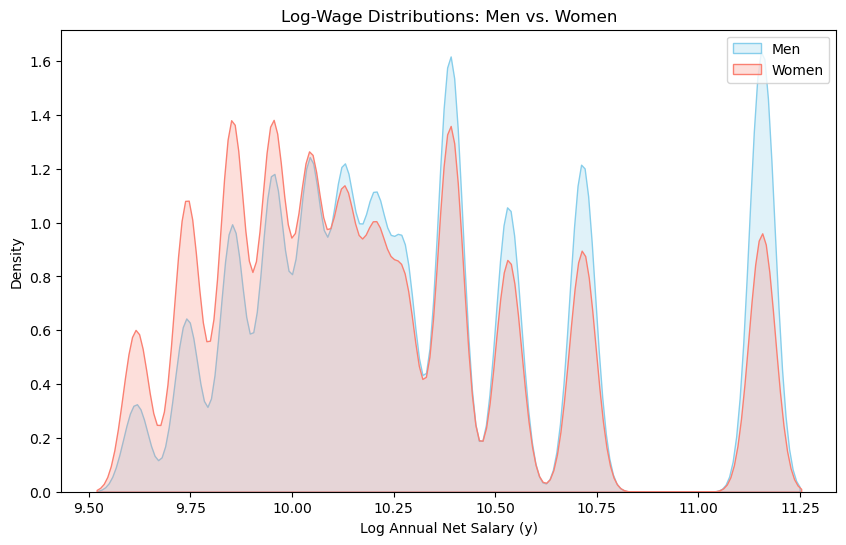

In [71]:
# The Kernel Density Estimate (KDE)

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_model[df_model['female'] == 0], x='y', label='Men', fill=True, color='skyblue')
sns.kdeplot(data=df_model[df_model['female'] == 1], x='y', label='Women', fill=True, color='salmon')

plt.title('Log-Wage Distributions: Men vs. Women')
plt.xlabel('Log Annual Net Salary (y)')
plt.ylabel('Density')
plt.legend()
plt.show()

The KDE plot visually confirms a systematic disparity in wage distributions between men and women.

- The female distribution is centered at a lower log-wage, representing a clear baseline pay gap.
- The rapid decline of the female density at high wage levels provides visual evidence of a "Glass Ceiling."

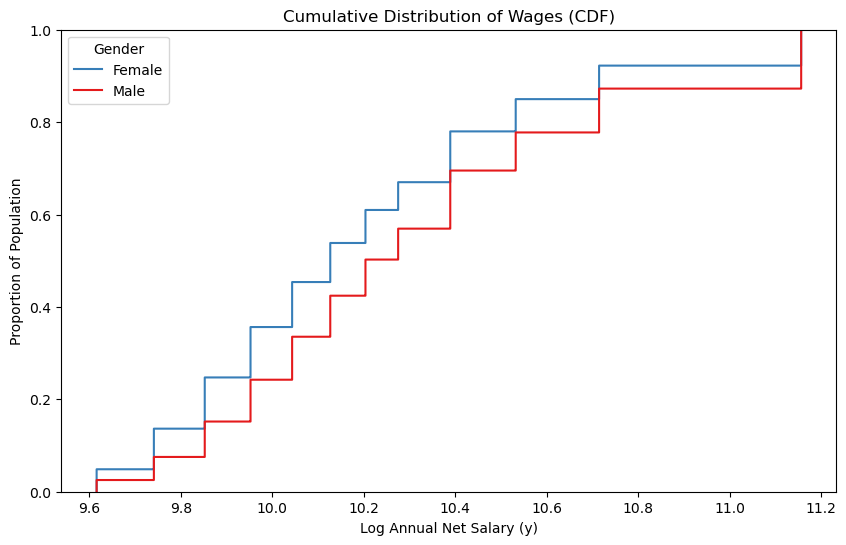

In [72]:
# Cumulative Distribution Function (CDF)

plt.figure(figsize=(10, 6))
sns.ecdfplot(data=df_model, x='y', hue='female', palette='Set1')

plt.title('Cumulative Distribution of Wages (CDF)')
plt.xlabel('Log Annual Net Salary (y)')
plt.ylabel('Proportion of Population')
plt.legend(title='Gender', labels=['Female', 'Male']) # Check your encoding (0/1)
plt.show()

The CDF illustrates the probability of earning at most a certain wage.

- The blue "Female" line stays consistently above and to the left of the red "Male" line across the entire distribution. This indicates that at every possible wage level, a higher cumulative proportion of women earn that amount or less compared to men.

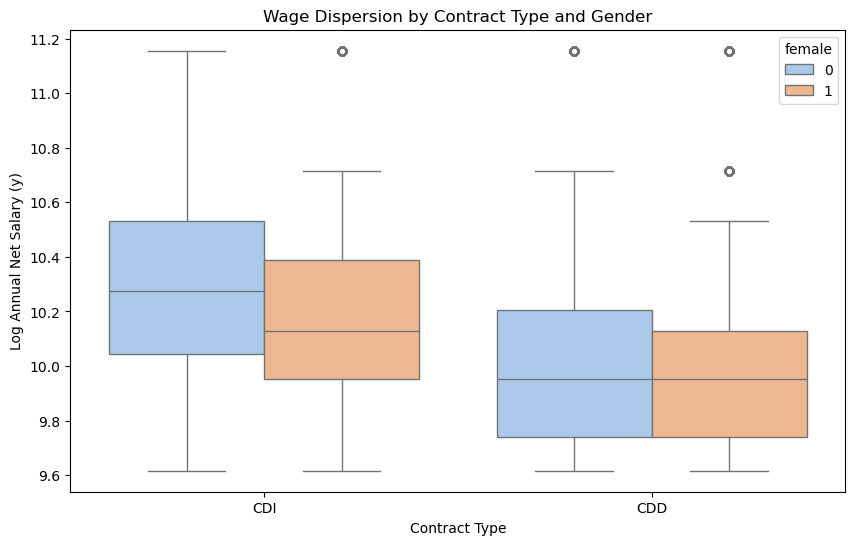

In [73]:
# Boxplot by Contract Type

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_model, x='CONT_TRAV', y='y', hue='female', palette='pastel')

plt.title('Wage Dispersion by Contract Type and Gender')
plt.xlabel('Contract Type')
plt.ylabel('Log Annual Net Salary (y)')
plt.show()

In [ ]:
# Quick Data Check: Calculate median log-wage by contract and gender
gap_check = df_model.groupby(['CONT_TRAV', 'female'])['y'].median().unstack()
gap_check['diff'] = gap_check[0] - gap_check[1] # Male Median - Female Median
print(gap_check)

female             0          1     diff
CONT_TRAV                               
CDD         9.952278   9.952278  0.00000
CDI        10.275051  10.126631  0.14842


This plot breaks down the gap by employment stability (CDI vs. CDD).

While we observe a clear gender wage gap in CDI contracts, the gap in CDD contracts is noticeably compressed, with median lines appearing almost identical.

- This suggests that the gender wage gap in our sample could be driven by factors prevalent in permanent employment—such as long-term promotion tracks, performance bonuses, and seniority—which are less applicable to temporary (CDD) roles.

- This finding justifies including CONT_TRAV (Contract Type) as a key control or interaction term in our Post-Lasso model, as the "treatment effect" of being female appears to vary significantly depending on the contract structure.

In [75]:
# Create a mask for high earners (Tranche 23)
top_earners = df_model[df_model['TRNNETO'] == 23]

# Compare the most common jobs (PCS) for men vs women in the elite bracket
print("Top 5 Occupations for Men (>50k€):")
print(top_earners[top_earners['female'] == 0]['PCS'].value_counts().head(5))

print("\nTop 5 Occupations for Women (>50k€):")
print(top_earners[top_earners['female'] == 1]['PCS'].value_counts().head(5))

Top 5 Occupations for Men (>50k€):
PCS
374D    4221
388A    4027
388C    2630
372B    1980
373B    1894
Name: count, dtype: int64

Top 5 Occupations for Women (>50k€):
PCS
372B    1225
372C    1206
374D    1149
373D    1068
373B    1059
Name: count, dtype: int64


In [76]:
# Group and calculate stats
summary = df_model.groupby('female')['annual_wage_euro'].agg(['mean', 'median'])
summary.index = ['Male', 'Female']

# Extract values as individual variables to perform the math
male_mean = summary.loc['Male', 'mean']
female_mean = summary.loc['Female', 'mean']

# Calculate the gaps
raw_gap = male_mean - female_mean
gap_percent = (raw_gap / male_mean) * 100

# Display results clearly
print(summary)
print("-" * 30)
print(f"Raw Wage Gap: {raw_gap:.2f} €")
print(f"Gender Pay Gap: {gap_percent:.2f}%")

                mean   median
Male    33370.240578  27000.0
Female  29542.430195  25000.0
------------------------------
Raw Wage Gap: 3827.81 €
Gender Pay Gap: 11.47%


In [77]:
# Calculate gap within the top 5 most frequent occupations
top_occupations = df_model['PCS'].value_counts().head(5).index
sorting_check = df_model[df_model['PCS'].isin(top_occupations)].groupby(['PCS', 'female'])['annual_wage_euro'].mean().unstack()
sorting_check['gap_pct'] = (1 - (sorting_check[1] / sorting_check[0])) * 100
print(sorting_check)

female             0             1    gap_pct
PCS                                          
388A    45837.649543  41669.949611   9.092307
542A    25881.188119  23349.993609   9.780055
543G    28185.515613  24584.582648  12.775828
551A    20530.048643  19092.324961   7.003021
641A    25153.816891  22668.765743   9.879420


In [78]:
# "Contract Type" Breakdown
contract_gap = df_model.groupby(['CONT_TRAV', 'female'])['annual_wage_euro'].mean().unstack()
contract_gap['gap_pct'] = (1 - (contract_gap[1] / contract_gap[0])) * 100
print(contract_gap)

female                0             1    gap_pct
CONT_TRAV                                       
CDD        24566.941392  23370.033113   4.872028
CDI        33474.065402  29658.606637  11.398253


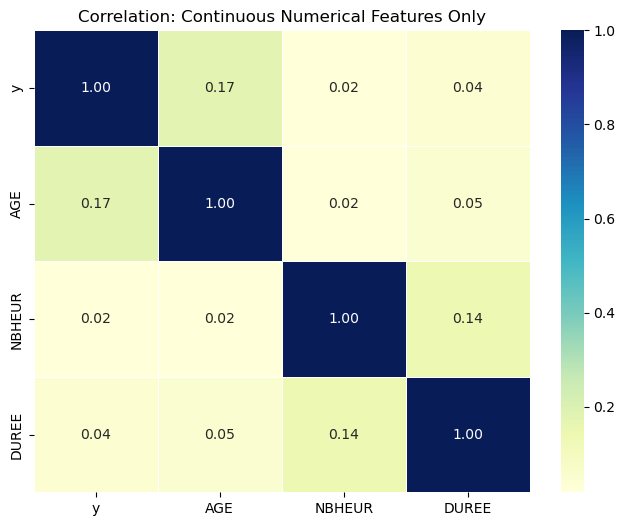

In [80]:
# Correlation Matrix

# Select only the continuous numerical features
# 'y' is log-wage, 'AGE' is experience, 'NBHEUR' is labor supply intensity
purely_numerical = ['y', 'AGE', 'NBHEUR','DUREE']

# Compute the correlation matrix
corr_num = df_model[purely_numerical].corr()

# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_num, annot=True, cmap='YlGnBu', fmt=".2f", linewidths=0.5)

plt.title('Correlation: Continuous Numerical Features Only')
plt.show()

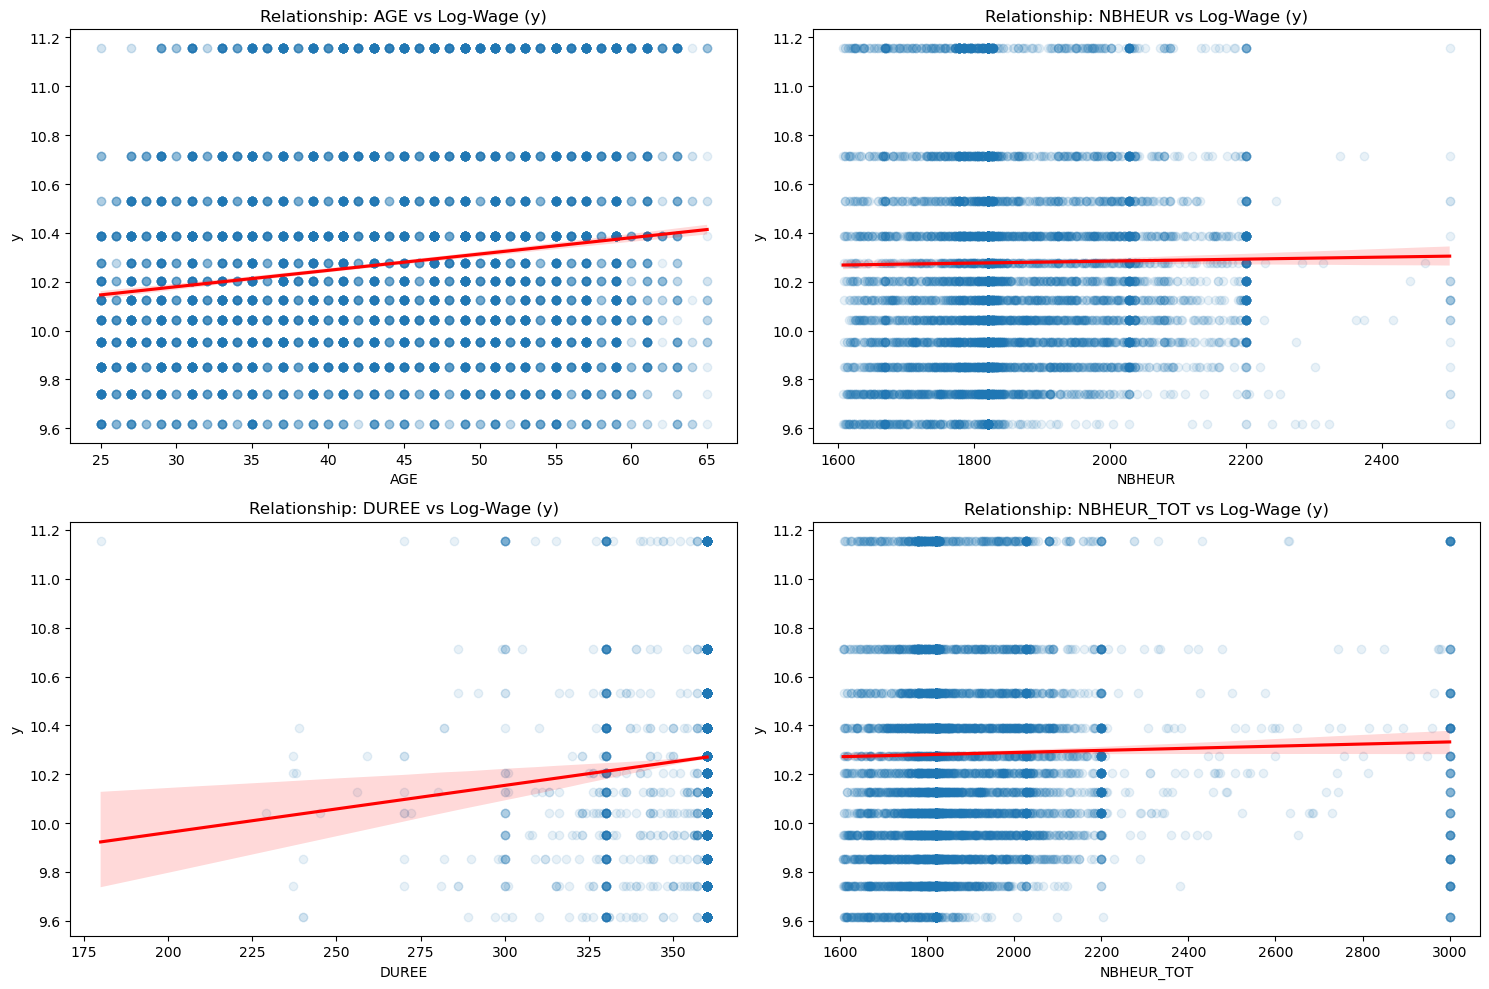

In [81]:
# For Numerical (Continuous) Variables: Pairplots & Regplots


# Define true continuous columns
num_features = ['AGE', 'NBHEUR', 'DUREE', 'NBHEUR_TOT']

# Create a multi-plot figure
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))
axes = axes.flatten()

for i, col in enumerate(num_features):
    # regplot shows the distribution and the linear trend with wage 'y'
    sns.regplot(data=df_model.sample(10000), x=col, y='y', ax=axes[i], 
                scatter_kws={'alpha':0.1}, line_kws={'color':'red'})
    axes[i].set_title(f'Relationship: {col} vs Log-Wage (y)')

plt.tight_layout()
plt.show()

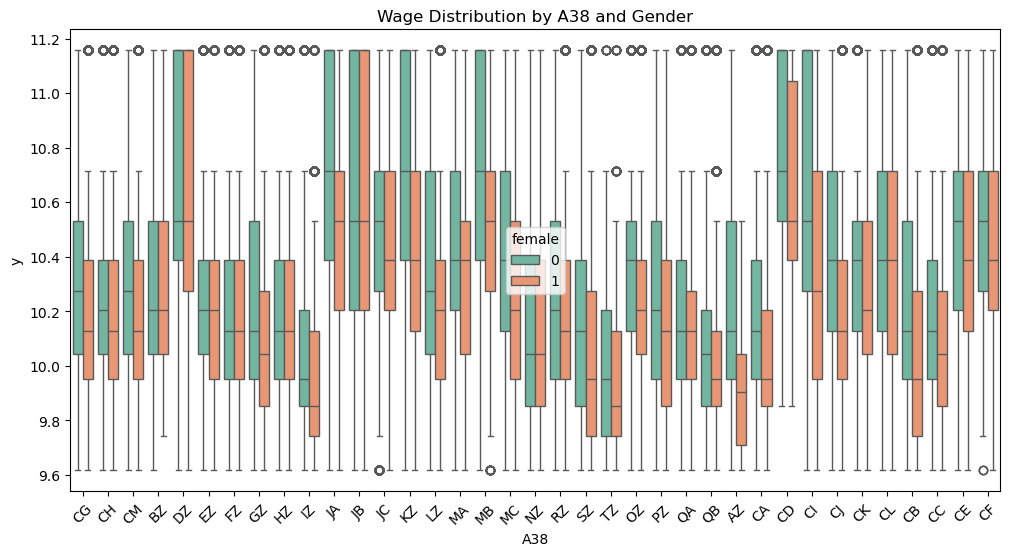

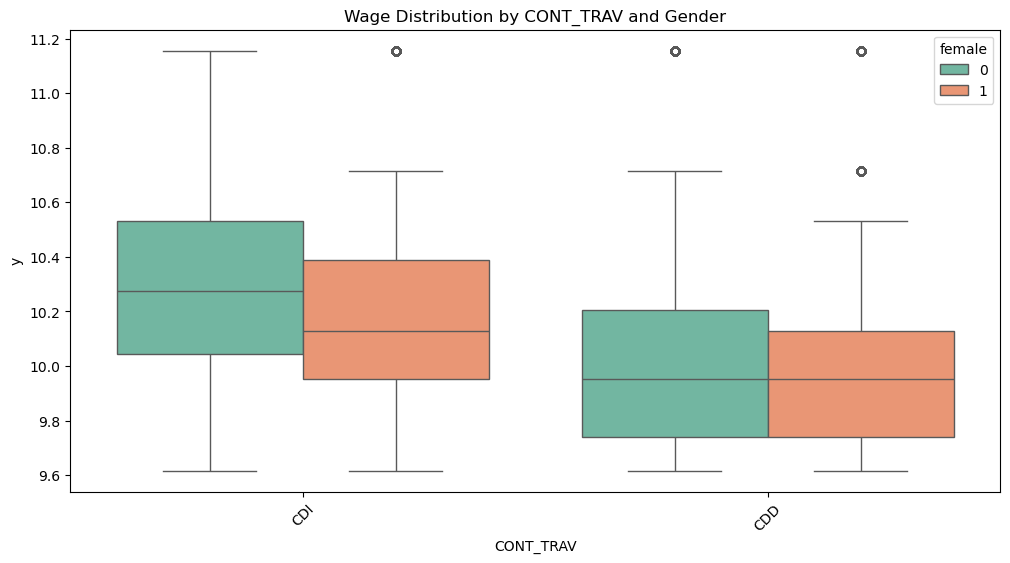

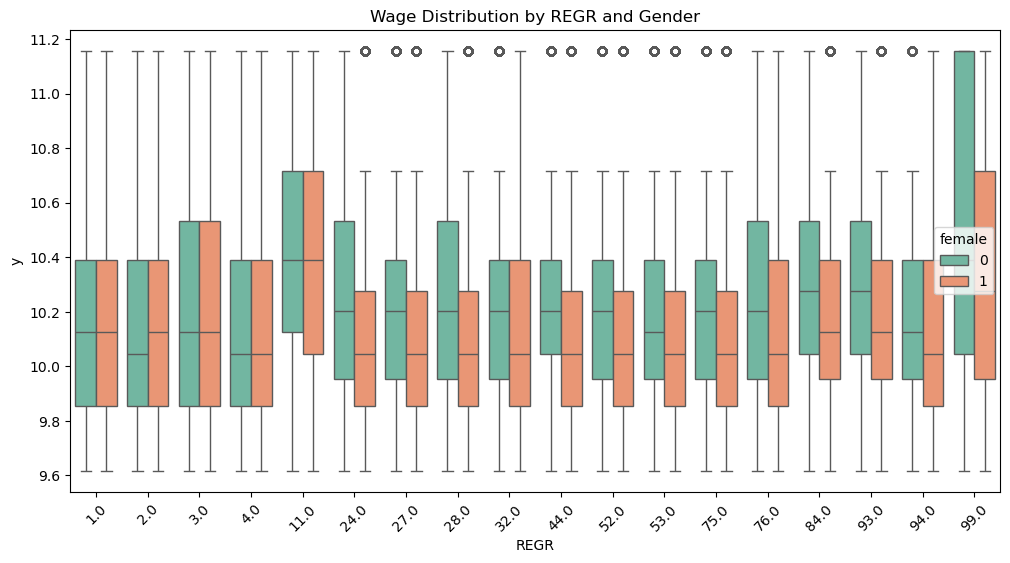

In [83]:
# For Categorical Variables: Boxplots & Mean Plots

# List of categorical features (excluding PCS due to the large number of categories)
cat_features = ['A38', 'CONT_TRAV', 'REGR']

for col in cat_features:
    plt.figure(figsize=(12, 6))
    # Boxplot shows the median and spread of wages for every category
    sns.boxplot(data=df_model, x=col, y='y', hue='female', palette='Set2')
    plt.title(f'Wage Distribution by {col} and Gender')
    plt.xticks(rotation=45)
    plt.show()

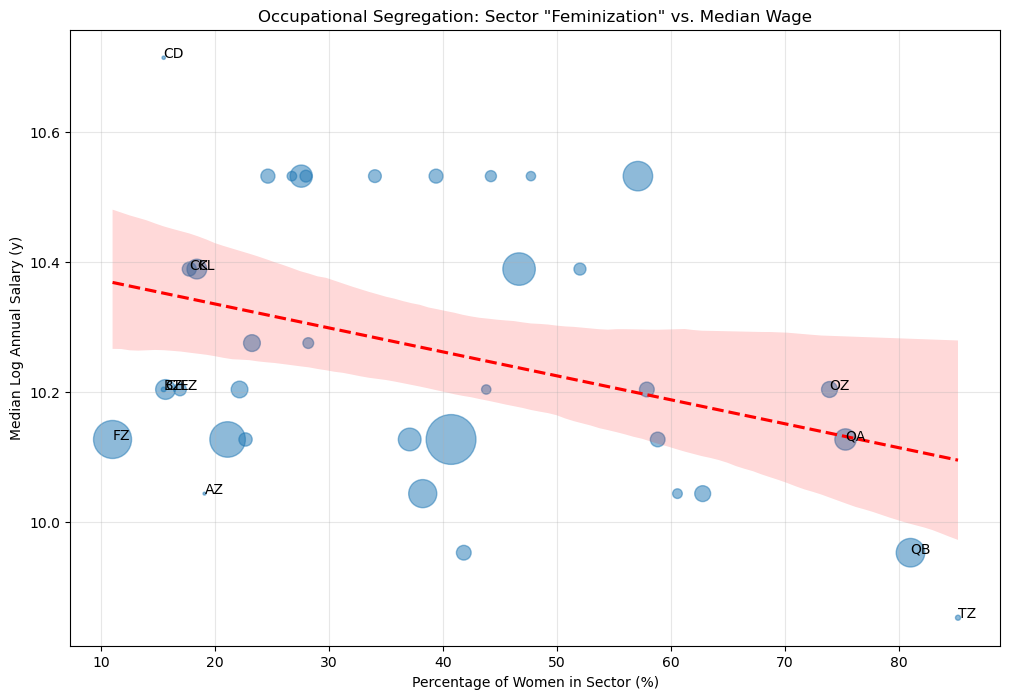

In [ ]:
# For the key variable A38 (Sector), we can also plot the relationship between "feminization" and median wage

# Calculate metrics per sector (A38)
sector_stats = df_model.groupby('A38').agg(
    female_pct=('female', 'mean'),
    median_wage=('y', 'median'),
    sample_size=('female', 'count')
).reset_index()

# Convert female_pct to actual percentage
sector_stats['female_pct'] *= 100

# Plotting the Relationship
plt.figure(figsize=(12, 8))
sns.regplot(data=sector_stats, x='female_pct', y='median_wage', 
            scatter_kws={'s': sector_stats['sample_size']/100, 'alpha':0.5},
            line_kws={'color':'red', 'linestyle':'--'})

# Annotate the top/bottom sectors for context
for i, txt in enumerate(sector_stats['A38']):
    if sector_stats['female_pct'].iloc[i] > 70 or sector_stats['female_pct'].iloc[i] < 20:
        plt.annotate(txt, (sector_stats['female_pct'].iloc[i], sector_stats['median_wage'].iloc[i]))

plt.title('Occupational Segregation: Sector "Feminization" vs. Median Wage')
plt.xlabel('Percentage of Women in Sector (%)')
plt.ylabel('Median Log Annual Salary (y)')
plt.grid(alpha=0.3)
plt.show()

In [85]:
# Identify the most "Feminized" vs "Masculinized" sectors
top_female_sectors = sector_stats.sort_values('female_pct', ascending=False).head(5)
top_male_sectors = sector_stats.sort_values('female_pct', ascending=True).head(5)

# Combine for a summary table
segregation_table = pd.concat([top_female_sectors, top_male_sectors])
segregation_table['Wage Rank'] = segregation_table['median_wage'].rank(ascending=False)

print("--- Occupational Segregation: Top 5 Female vs. Top 5 Male Sectors ---")
print(segregation_table[['A38', 'female_pct', 'median_wage', 'sample_size']].to_string(index=False))

--- Occupational Segregation: Top 5 Female vs. Top 5 Male Sectors ---
A38  female_pct  median_wage  sample_size
 TZ   85.218703     9.852194         1326
 QB   81.047205     9.952278        42284
 QA   75.338799    10.126631        23539
 OZ   73.933577    10.203592        13128
 SZ   62.797256    10.043249        13120
 FZ   10.972419    10.126631        74906
 BZ   15.458515    10.203592         1145
 CD   15.463918    10.714418          582
 CH   15.625000    10.203592        20288
 EZ   16.897305    10.203592         8238


The "Fisherman's Problem" suggests that a significant portion of the raw gender wage gap is driven by the concentration of women in lower-paying sectors rather than purely by within-job discrimination.

- The scatter plot reveals a clear negative correlation between the "feminization" of a sector and its median remuneration.
- Large sectors like QB (Health and Social Work) are high-employment hubs for women (81%) but sit significantly lower on the wage scale (y=9.95) compared to male-dominated industrial sectors.
- Sectors like CD (Coking and Refining), which have very low female participation (15.5%), command the highest median log-wages in our selection (y=10.71).
- Women are not just "earning less"; they are being "sorted" into sectors that have lower base-pay structures.

In [87]:
import statsmodels.formula.api as smf

# Define the quantiles (from 0.1 to 0.9)
quantiles = np.arange(0.1, 1.0, 0.1)

# Fit the Quantile Regression models (excluding PCS for now since it has 400+ categories; including it in a Quantile Regression will make the model extremely slow and might lead to "over-controlling").
formula = 'y ~ female + AGE + NBHEUR + DUREE + C(CONT_TRAV) + C(REGR)'

qr_results = []
for q in quantiles:
    model = smf.quantreg(formula, df_model).fit(q=q)
    qr_results.append({
        'quantile': q,
        'coef': model.params['female'],
        'lb': model.conf_int().loc['female', 0],
        'ub': model.conf_int().loc['female', 1]
    })
df_qr = pd.DataFrame(qr_results)

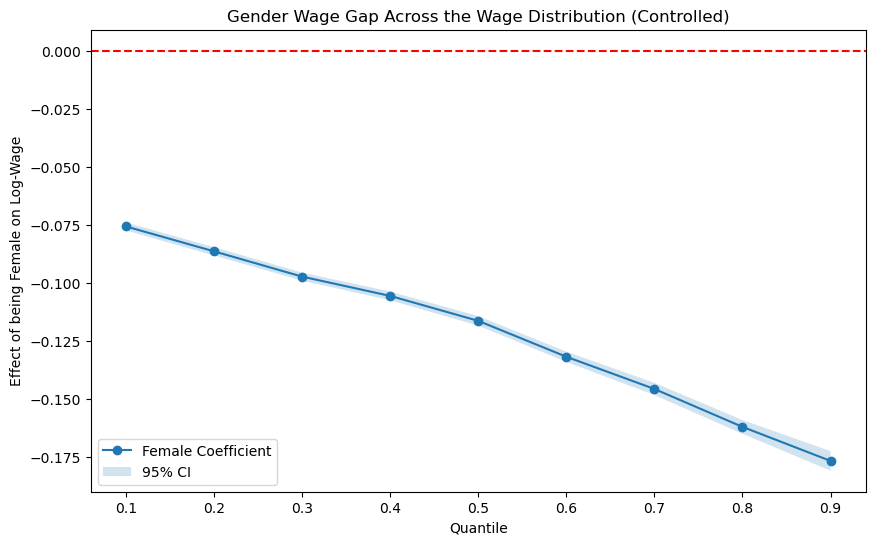

In [88]:
plt.figure(figsize=(10, 6))
plt.plot(df_qr['quantile'], df_qr['coef'], marker='o', label='Female Coefficient')
plt.fill_between(df_qr['quantile'], df_qr['lb'], df_qr['ub'], alpha=0.2, label='95% CI')
plt.axhline(y=0, color='r', linestyle='--')
plt.title('Gender Wage Gap Across the Wage Distribution (Controlled)')
plt.xlabel('Quantile')
plt.ylabel('Effect of being Female on Log-Wage')
plt.legend()
plt.show()

- The gender coefficient becomes increasingly negative as we move from the 10th to the 90th percentile. This provides strong empirical evidence for a "Glass Ceiling."
- The widening gap at the 90th percentile (q=0.9) likely captures unobserved factors such as gender bias in promotions, performance-based pay, and the "motherhood penalty" which tends to accumulate more significantly at higher career stages.

Causal Graph for Gender Wage Gap Identification:


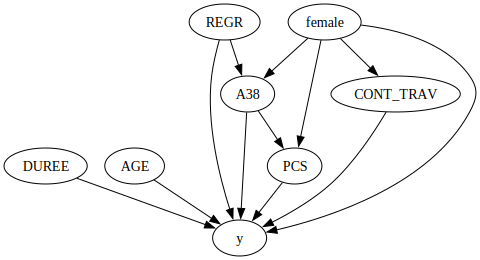

In [89]:
import collections
import collections.abc

# Fix for Python 3.10+ compatibility
collections.Iterable = collections.abc.Iterable

from causalgraphicalmodels import CausalGraphicalModel

# Define the structure
dag = CausalGraphicalModel(
    nodes=["female", "y", "AGE", "DUREE", "PCS", "CONT_TRAV", "A38", "REGR"],
    edges=[
        # Direct Treatment Effect
        ("female", "y"),           
        
        # The "Sorting" Mediators (Proved by your EDA)
        ("female", "A38"),        # Horizontal Segregation
        ("female", "PCS"),        # Vertical Segregation
        ("female", "CONT_TRAV"),  # Contract Type Sorting
        
        # Structural Chains
        ("A38", "PCS"),           # Sector determines available jobs
        ("REGR", "A38"),          # Geography determines available industries
        
        # Impact on Wages (y)
        ("A38", "y"),              
        ("PCS", "y"),              
        ("CONT_TRAV", "y"),        
        ("AGE", "y"),             # Human Capital
        ("REGR", "y"),            # Regional Price Levels/Cost of Living
        ("DUREE", "y")            # Seniority/Experience effect
    ]
)

# Draw the graph
print("Causal Graph for Gender Wage Gap Identification:")
dag.draw()

 Identification Strategy: Causal Graph (DAG)
 
 To isolate the causal effect of gender on wages, we define the following Directed Acyclic Graph (DAG) to map our structural assumptions:
 
 The Causal Model:
 - Treatment (D): female. We aim to estimate the "unexplained" penalty associated with this variable.
 - Outcome (Y): y (Log-Wage). The target variable representing annual earnings.
 - Confounders (X): AGE and REGR (Region). These variables influence the entire system. AGE serves as a proxy for human capital/experience, while REGR determines the industrial landscape (A38) and local cost-of-living premiums.
 - Structural Mediators (M): A38 (Sector), PCS (Occupation), and CONT_TRAV (Contract Type).
    - Our EDA confirmed a "Sorting" mechanism where female $\rightarrow$ A38.Further, A38 $\rightarrow$ PCS represents the industrial hierarchy where the sector of activity dictates the available job roles.
 
 
 Identification Assumptions
 - Direct Effect: The edge female $\rightarrow$ y represents the ceteris paribus effect. By blocking the paths through our mediators, we isolate the residual gender wage gap—the portion of the penalty that remains when comparing individuals with identical structural and human capital profiles.
 - Sorting ("Fisherman's Problem"): Unlike simpler models, our DAG explicitly recognizes that gender influences the Sector (A38), which in turn influences the Occupation (PCS). By controlling for this chain, we account for both horizontal segregation (sorting into low-pay sectors) and vertical segregation (sorting into low-pay roles)
 - Closing Backdoor Paths: We satisfy the Backdoor Criterion by controlling for AGE and REGR. Since REGR influences both the likelihood of a certain industry being present and the overall wage level, it is a critical source of potential bias that we must "partial out."
 
Variable Selection for PostLasso:
Based on our causal structure, we define the following feature sets for the Post-Lasso estimation:
- Target (Y): y (Log-wage).
- Treatment (D): female (Binary indicator).
- High-Dimensional Controls (X):
    - Continuous/Numeric: AGE, DUREE, NBHEUR.
    - Categorical (One-Hot Encoded): PCS (Job classification), A38 (Industry sector), REGR (Region), CONT_TRAV (Contract type)


 

In [90]:
import os

# Use '../' to step out of the notebooks folder first
output_dir = "../data/processed" 
output_filename = "sample_dataset.csv"
full_path = os.path.join(output_dir, output_filename)

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Export the processed DataFrame
df_model.to_csv(full_path, index=False)

# Verification
if os.path.exists(full_path):
    file_size = os.path.getsize(full_path) / (1024 * 1024)
    print(f"✅ Success! File saved at: {full_path}")
    print(f"📊 Total Rows: {len(df_model):,}")
    print(f"💾 File Size: {file_size:.2e} MB")
else:
    print("❌ Error: File was not saved.")

✅ Success! File saved at: ../data/processed/sample_dataset.csv
📊 Total Rows: 762,661
💾 File Size: 1.13e+02 MB
